To do notes
- check how fixed H matrix in nmf impacts quality of reconstruction vs variable H
- whats an acceptable mse for nmf reconstruction
- Use VisiumHD Dataset as a standin for "complete" Xenium dataset (how does the chosen panel impact reconstruction, what properties do nicely reconstructed genes have)
- ask ankit about annotation and segmentation of spatial dataset

## Prepare Environment

### Modules

In [1]:
from pathlib import Path
from typing import Union
import itertools
import functools
import warnings
from math import ceil, sqrt, log2, sqrt
from tqdm import tqdm

import numpy as np
np.random.seed(5)
import pandas as pd
import torch
import scvi
import scanpy as sc
import sklearn
from sklearn.decomposition import non_negative_factorization

import matplotlib.pyplot as plt
import seaborn as sns


/opt/homebrew/Caskroom/miniforge/base/envs/scvi_mps-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print(
    torch.backends.mps.is_available(),
    torch.cuda.is_available()
)

True False


### Utils

In [3]:
def create_folders(base_path: str, structure: dict, current_path: Union[str, Path] = None) -> None:
    if current_path is None:
        current_path = Path(base_path)
    Path(current_path).mkdir(exist_ok=True)
    for key, value in structure.items():
        new_path = current_path / str(key)
        if isinstance(value, dict):
            Path(new_path).mkdir(exist_ok=True)
            create_folders(base_path, value, new_path)

def bootstrap(n_iterations, sample_size):
    def decorator(func):
        @functools.wraps(func)
        def wrapper(data, *args, **kwargs):
            results = []
            for _ in range(n_iterations):
                result_dict = {}
                sample = data[np.random.choice(data.shape[0], size=sample_size, replace=False), :]
                result_dict["sample"] = sample
                result_dict["output"] = func(sample, *args, **kwargs)
                results.append(result_dict)
            return results
        return wrapper
    return decorator

### Folder Structure

In [4]:
create_folders(
    str(Path.cwd()),
    {
        "data": {
            "inputQuery": {},
            "inputRef": {},
            "nico_out": {},
        }
    }
)

### Dataloading

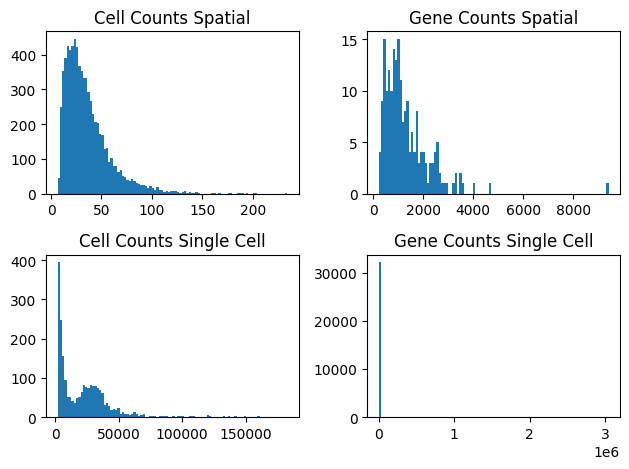

(AnnData object with n_obs × n_vars = 7416 × 203
     obs: 'umi_sct', 'log_umi_sct', 'gene_sct', 'log_gene_sct', 'umi_per_gene_sct', 'log_umi_per_gene_sct', 'leiden0.4', 'leiden0.5', 'nico_ct'
     var: 'Intercept_sct', 'log_umi_sct', 'theta_sct', 'Intercept_step1_sct', 'log_umi_step1_sct', 'dispersion_step1_sct', 'genes_step1_sct', 'log10_gmean_sct'
     uns: 'leiden', 'leiden0.5_colors', 'neighbors', 'pca', 'umap'
     obsm: 'X_pca', 'X_umap', 'spatial'
     varm: 'PCs'
     obsp: 'connectivities', 'distances',
 AnnData object with n_obs × n_vars = 2239 × 32287
     obs: 'cluster')

In [5]:
adata_sp = sc.read_h5ad(Path.cwd() / "data" / "nico_out" / "nico_celltype_annotation.h5ad")
adata_sc = sc.read_h5ad(Path.cwd() / "data" / "inputRef" / "input_ref.h5ad")

fig, axs = plt.subplots(2, 2) 
axs = axs.flatten()
axs[0].hist(adata_sp.X.toarray().sum(axis=1), bins=100)
axs[0].set_title("Cell Counts Spatial")
axs[1].hist(adata_sp.X.toarray().sum(axis=0), bins=100)
axs[1].set_title("Gene Counts Spatial")
axs[2].hist(adata_sc.X.toarray().sum(axis=1), bins=100)
axs[2].set_title("Cell Counts Single Cell")
axs[3].hist(adata_sc.X.toarray().sum(axis=0), bins=100)
axs[3].set_title("Gene Counts Single Cell")
plt.tight_layout()
plt.show()
adata_sp, adata_sc

### Dataprep

In [12]:

sc.pp.filter_genes(adata_sc, min_counts=3)

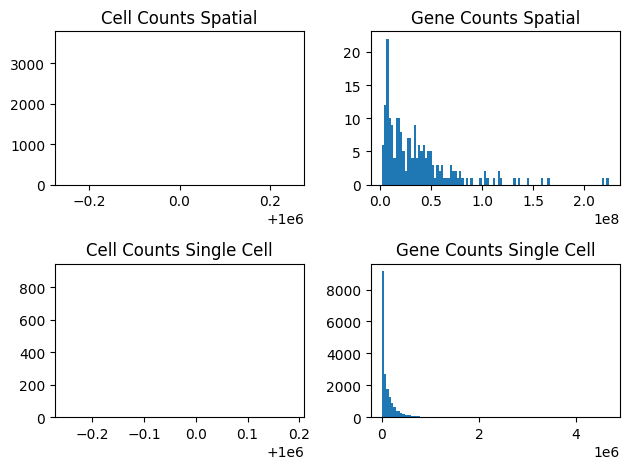

(AnnData object with n_obs × n_vars = 7416 × 203
     obs: 'umi_sct', 'log_umi_sct', 'gene_sct', 'log_gene_sct', 'umi_per_gene_sct', 'log_umi_per_gene_sct', 'leiden0.4', 'leiden0.5', 'nico_ct'
     var: 'Intercept_sct', 'log_umi_sct', 'theta_sct', 'Intercept_step1_sct', 'log_umi_step1_sct', 'dispersion_step1_sct', 'genes_step1_sct', 'log10_gmean_sct', 'n_counts'
     uns: 'leiden', 'leiden0.5_colors', 'neighbors', 'pca', 'umap', 'log1p'
     obsm: 'X_pca', 'X_umap', 'spatial'
     varm: 'PCs'
     obsp: 'connectivities', 'distances',
 AnnData object with n_obs × n_vars = 2239 × 18498
     obs: 'cluster'
     var: 'n_counts'
     uns: 'log1p')

In [5]:
sc.pp.filter_genes(adata_sp, min_counts=3)
sc.pp.log1p(adata_sp)
sc.pp.normalize_total(adata_sp, target_sum=1e6)

sc.pp.filter_genes(adata_sc, min_counts=3)
sc.pp.log1p(adata_sc)
sc.pp.normalize_total(adata_sc, target_sum=1e6)

fig, axs = plt.subplots(2, 2) 
axs = axs.flatten()
axs[0].hist(adata_sp.X.toarray().sum(axis=1), bins=100)
axs[0].set_title("Cell Counts Spatial")
axs[1].hist(adata_sp.X.toarray().sum(axis=0), bins=100)
axs[1].set_title("Gene Counts Spatial")
axs[2].hist(adata_sc.X.toarray().sum(axis=1), bins=100)
axs[2].set_title("Cell Counts Single Cell")
axs[3].hist(adata_sc.X.toarray().sum(axis=0), bins=100)
axs[3].set_title("Gene Counts Single Cell")
plt.tight_layout()
plt.show()
adata_sp, adata_sc

In [279]:
# Choose one celltype from the available shared types to filter adata objects with
set.intersection(
    set(adata_sc.obs["cluster"]),
    set(adata_sp.obs["nico_ct"])
)

{'BZE',
 'Blood vasc.',
 'Cycling/GC B cell',
 'Glial',
 'Goblet',
 'Lymphatic',
 'MZE',
 'Macrophage',
 'Paneth',
 'Plasma',
 'Rest B',
 'Stem/TA',
 'Stroma',
 'T cell',
 'TZE',
 'Tuft',
 'cDC/monocyte',
 'neurons/enteroendocrine',
 'pDC'}

In [84]:
celltype = "Stem/TA"
adata_sc_filtered = adata_sc[adata_sc.obs["cluster"] == celltype].copy()
adata_sp_filtered = adata_sp[adata_sp.obs["nico_ct"] == celltype].copy()
adata_sc_filtered, adata_sp_filtered

(AnnData object with n_obs × n_vars = 420 × 32287
     obs: 'cluster',
 AnnData object with n_obs × n_vars = 997 × 203
     obs: 'umi_sct', 'log_umi_sct', 'gene_sct', 'log_gene_sct', 'umi_per_gene_sct', 'log_umi_per_gene_sct', 'leiden0.4', 'leiden0.5', 'nico_ct'
     var: 'Intercept_sct', 'log_umi_sct', 'theta_sct', 'Intercept_step1_sct', 'log_umi_step1_sct', 'dispersion_step1_sct', 'genes_step1_sct', 'log10_gmean_sct'
     uns: 'leiden', 'leiden0.5_colors', 'neighbors', 'pca', 'umap'
     obsm: 'X_pca', 'X_umap', 'spatial'
     varm: 'PCs'
     obsp: 'connectivities', 'distances')

In [85]:
from fixed_matrix_NMF import _fit_transform_adapted
from sklearn.decomposition._nmf import _beta_divergence
from sklearn._config import config_context

X = adata_sc_filtered.X.toarray().copy().T
with config_context(assume_finite=True):
    W, H, n_iter = _fit_transform_adapted(X, n_components=3, W=None, H=None)

reconstruction_err_ = _beta_divergence(X, W, H, "frobenius", square_root=True)

/Users/egerc/Documents/Projects/spatial_transcript_inference/fixed_matrix_NMF.py:224: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


In [86]:
X = adata_sc_filtered.X.toarray().copy().T
with config_context(assume_finite=True):
    W, H, n_iter = _fit_transform_adapted(X, n_components=3, W=None, H=None)

reconstruction_err_ = _beta_divergence(X, W, H, "frobenius", square_root=True)

/Users/egerc/Documents/Projects/spatial_transcript_inference/fixed_matrix_NMF.py:224: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


In [284]:
H

array([[21.261623  , 28.685692  , 16.048191  , ...,  0.12589173,
         0.5273299 ,  0.        ],
       [ 1.7029352 ,  0.        , 13.322942  , ...,  2.7921114 ,
         1.4286709 ,  0.9339237 ],
       [17.670927  , 10.897014  , 15.449195  , ...,  0.        ,
         0.        ,  0.08054125]], dtype=float32)

## Benchmarking

In [87]:
model_nmf = sklearn.decomposition.NMF(
    n_components=3,
)
W = model_nmf.fit_transform(
   X=adata_sc_filtered.X.transpose(),
)
H = model_nmf.components_
sklearn.metrics.mean_squared_error(
    adata_sc_filtered.X.transpose().toarray(),
    W @ H
)

/opt/homebrew/Caskroom/miniforge/base/envs/scvi_mps-env/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


4.443471908569336

In [88]:
W, H, n_iter = non_negative_factorization(X, n_components=3, )

/opt/homebrew/Caskroom/miniforge/base/envs/scvi_mps-env/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


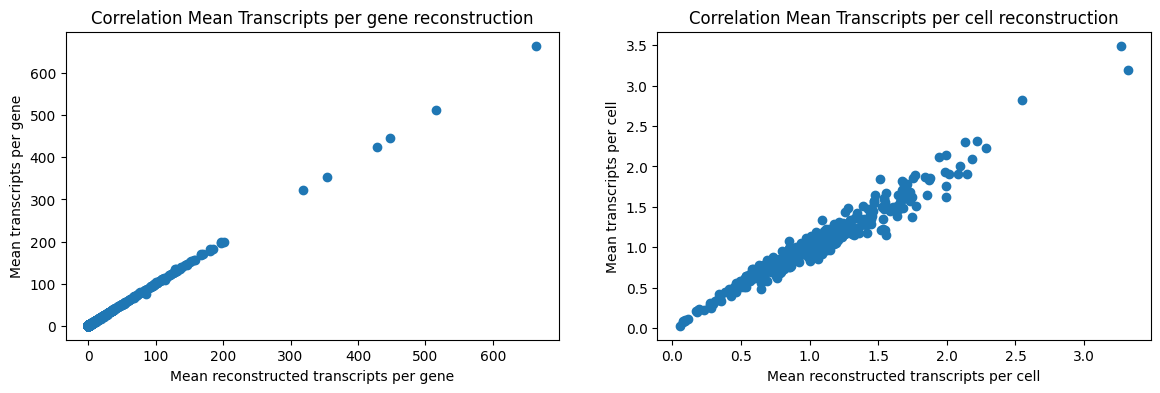

Correlation Coeff Gene Reconstruction: 0.9999169658870194 
Correlation Coeff Cell Reconstruction: 0.9769244955442047


In [89]:
fig, axs = plt.subplots(1, 2, figsize=(14,4))

axs[0].scatter(
    adata_sc_filtered.X.transpose().toarray().mean(axis=1),
    (W @ H).mean(axis=1),
)
axs[0].set_title("Correlation Mean Transcripts per gene reconstruction")
axs[0].set_xlabel("Mean reconstructed transcripts per gene")
axs[0].set_ylabel("Mean transcripts per gene")

axs[1].scatter(
    adata_sc_filtered.X.transpose().toarray().mean(axis=0),
    (W @ H).mean(axis=0),
)
axs[1].set_title("Correlation Mean Transcripts per cell reconstruction")
axs[1].set_xlabel("Mean reconstructed transcripts per cell")
axs[1].set_ylabel("Mean transcripts per cell")
plt.show()

print(
    f"Correlation Coeff Gene Reconstruction: {np.corrcoef(adata_sc_filtered.X.transpose().toarray().mean(axis=1), (W @ H).mean(axis=1))[0, 1]}",
    f"\nCorrelation Coeff Cell Reconstruction: {np.corrcoef(adata_sc_filtered.X.transpose().toarray().mean(axis=0), (W @ H).mean(axis=0))[0, 1]}",
)

In [288]:
np.isin(adata_sc_filtered.var_names, adata_sp_filtered.var_names)

array([False, False, False, ..., False, False, False])

**Taken from the sklearn NMF class description:**

Non-Negative Matrix Factorization (NMF).

Find two non-negative matrices, i.e. matrices with all non-negative elements, (W, H)
whose product approximates the non-negative matrix X. This factorization can be used
for example for dimensionality reduction, source separation or topic extraction.

The objective function is:
$$
L(W, H) = \frac{1}{2} \| X - WH \|_{\text{loss}}^2
+ \alpha_W \cdot l1\_ratio \cdot n_{\text{features}} \cdot \|\text{vec}(W)\|_1
+ \alpha_H \cdot l1\_ratio \cdot n_{\text{samples}} \cdot \|\text{vec}(H)\|_1
+ \frac{1}{2} \alpha_W \cdot (1 - l1\_ratio) \cdot n_{\text{features}} \cdot \|W\|_{Fro}^2
+ \frac{1}{2} \alpha_H \cdot (1 - l1\_ratio) \cdot n_{\text{samples}} \cdot \|H\|_{Fro}^2
$$

where $||A||_{Fro}^2 = \sum_{i,j} A_{ij}^2$ (Frobenius norm) and
$||vec(A)||_1 = \sum_{i,j} abs(A_{ij})$ (Elementwise L1 norm).

The generic norm $\| X - WH \|_{\text{loss}}$ may represent
the Frobenius norm or another supported beta-divergence loss.
The choice between options is controlled by the `beta_loss` parameter.

The regularization terms are scaled by `n_features` for `W` and by `n_samples` for
`H` to keep their impact balanced with respect to one another and to the data fit
term as independent as possible of the size `n_samples` of the training set.

The objective function is minimized with an alternating minimization of W
and H.

Note that the transformed data is named W and the components matrix is named H. In
the NMF literature, the naming convention is usually the opposite since the data
matrix X is transposed.


In [289]:
from sklearn.decomposition import non_negative_factorization

In [290]:
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [2., 4., 4., ..., 0., 2., 2.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [291]:
X = adata_sc_filtered.X.toarray().copy()
#H = np.array(np.random.rand(3, 420), dtype=X.dtype)
#H = np.ones((3, 420), dtype=X.dtype)
W, H, n_iter = non_negative_factorization(X, W=None, n_components=10)

/opt/homebrew/Caskroom/miniforge/base/envs/scvi_mps-env/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


In [292]:
H.shape

(10, 32287)

In [293]:
X = adata_sc_filtered.X.toarray().copy()
#H = np.array(np.random.rand(3, 420), dtype=X.dtype)
#H = np.ones((3, 420), dtype=X.dtype)
non_negative_factorization(X, W=None, H=H, n_components=3, update_H=False, init="custom")

ValueError: Array with wrong first dimension passed to NMF (input H). Expected 3, but got 10.

In [ ]:
H_sp = H[:, np.isin(adata_sc_filtered.var_names, adata_sp_filtered.var_names)]

In [ ]:
X_sp = adata_sp_filtered.X.toarray().copy()
#H = np.array(np.random.rand(3, 420), dtype=X.dtype)
#H = np.ones((3, 420), dtype=X.dtype)
W_sp, H_sp, n_iter = non_negative_factorization(X_sp, W=None, H=H_sp, n_components=10, update_H=False, init="custom")

In [ ]:
adata_sp_filtered.X.toarray().mean(axis=1).shape

(997,)

In [ ]:
X_sp = adata_sp_filtered.X.toarray().copy()
#H = np.array(np.random.rand(3, 420), dtype=X.dtype)
#H = np.ones((3, 420), dtype=X.dtype)
W_sp, H_sp, n_iter = non_negative_factorization(X_sp, n_components=10)

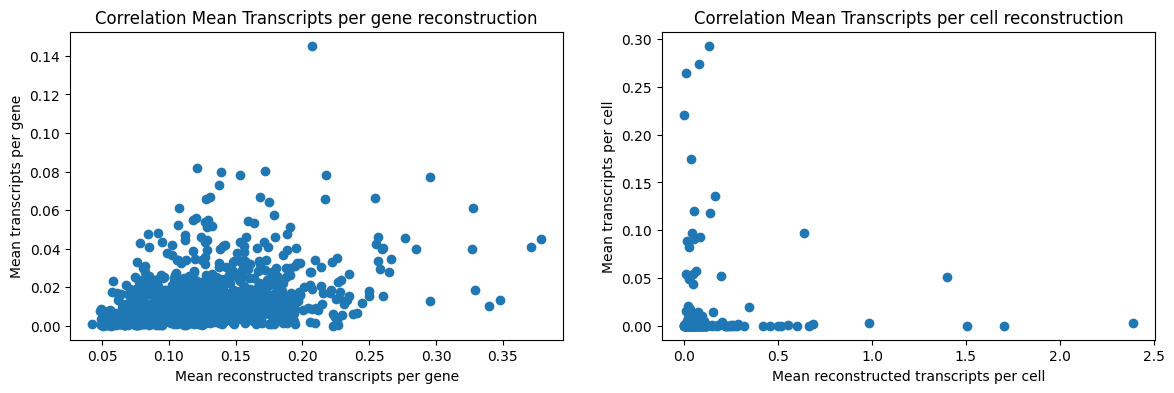

Correlation Coeff Gene Reconstruction: 0.36657244105478337 
Correlation Coeff Cell Reconstruction: -0.015983848718396563


In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(14,4))

axs[0].scatter(
    X_sp.mean(axis=1),
    (W_sp @ H_sp).mean(axis=1),
)
axs[0].set_title("Correlation Mean Transcripts per gene reconstruction")
axs[0].set_xlabel("Mean reconstructed transcripts per gene")
axs[0].set_ylabel("Mean transcripts per gene")

axs[1].scatter(
    X_sp.mean(axis=0),
    (W_sp @ H_sp).mean(axis=0),
)
axs[1].set_title("Correlation Mean Transcripts per cell reconstruction")
axs[1].set_xlabel("Mean reconstructed transcripts per cell")
axs[1].set_ylabel("Mean transcripts per cell")
plt.show()

print(
    f"Correlation Coeff Gene Reconstruction: {np.corrcoef(X_sp.mean(axis=1), (W_sp @ H_sp).mean(axis=1))[0, 1]}",
    f"\nCorrelation Coeff Cell Reconstruction: {np.corrcoef(X_sp.mean(axis=0), (W_sp @ H_sp).mean(axis=0))[0, 1]}",
)

/opt/homebrew/Caskroom/miniforge/base/envs/scvi_mps-env/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/scvi_mps-env/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/scvi_mps-env/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/scvi_mps-env/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/scvi_mps-env/

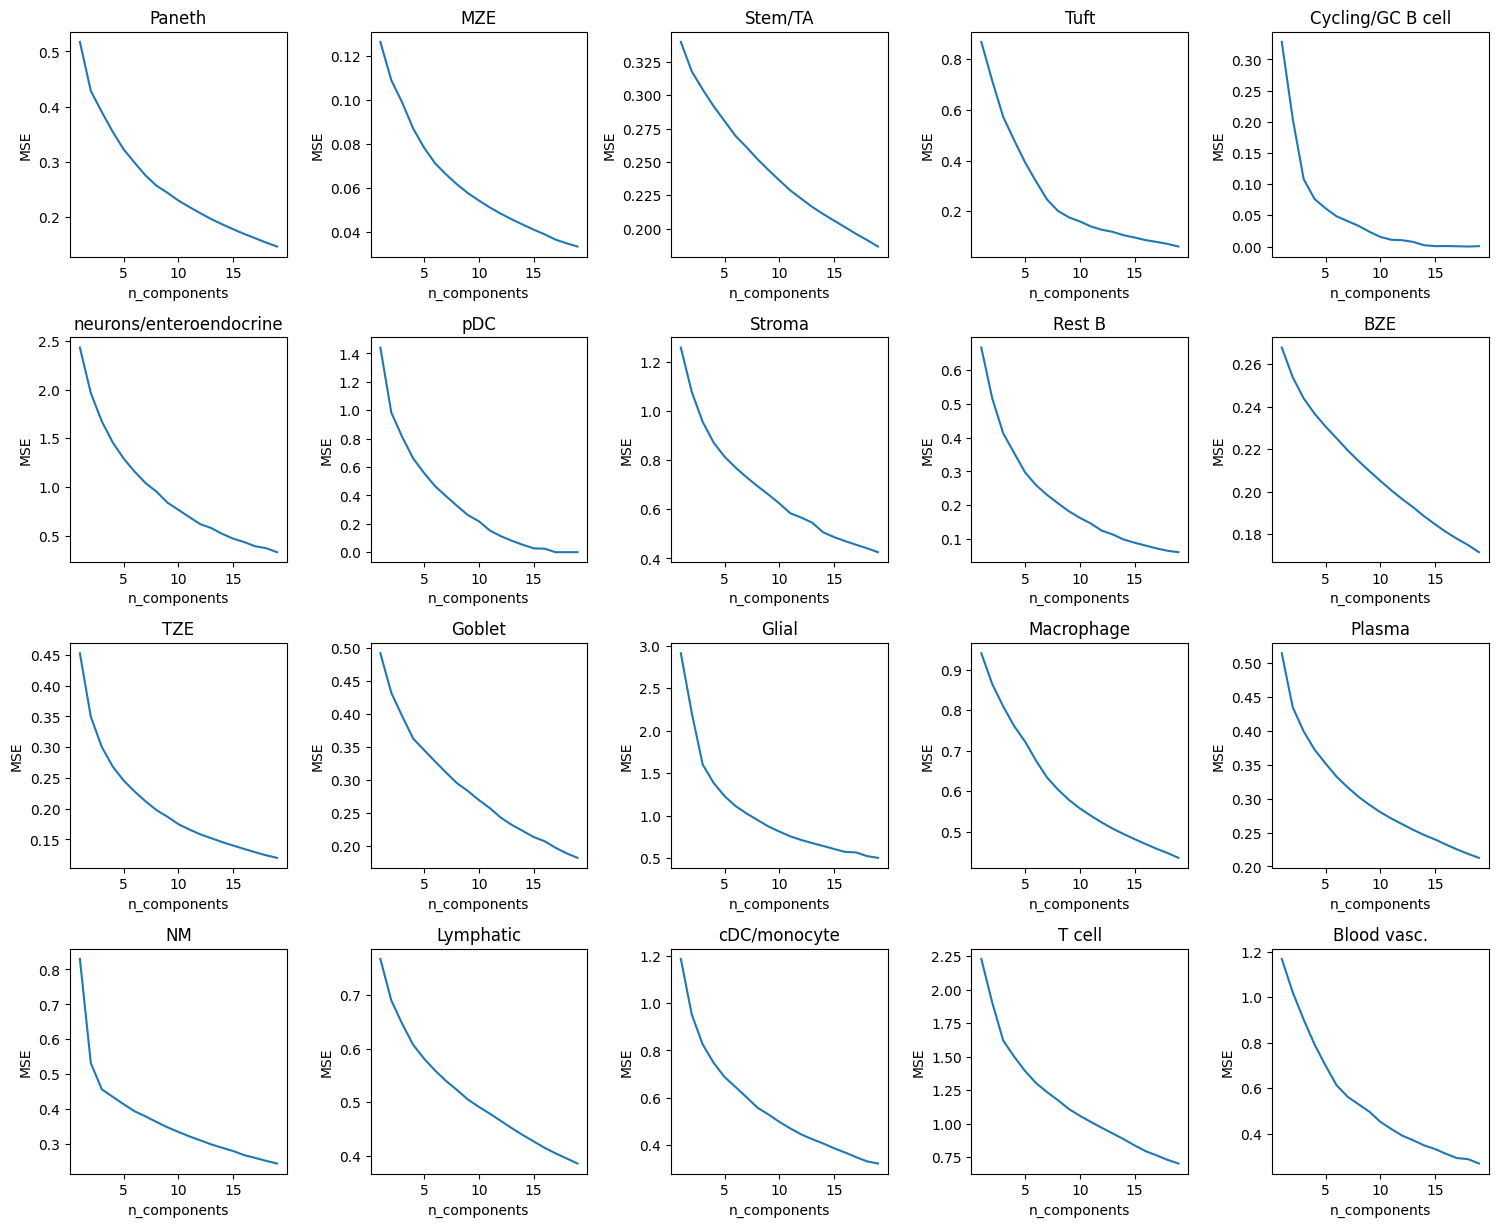

In [294]:
cell_types = set(adata_sp.obs["nico_ct"])
n_components_limit = 20
n_cell_types = len(cell_types)
grid_size = ceil(sqrt(n_cell_types))  # Square-like grid
fig, axes = plt.subplots(grid_size, grid_size, figsize=(grid_size * 3, grid_size * 3))  # Adjust figure size
axes = axes.flatten()
for i, cell_type in enumerate(cell_types):
    ax = axes[i] 
    X = adata_sp[adata_sp.obs["nico_ct"] == cell_type].X.toarray().copy()
    errors = [
        sklearn.metrics.mean_squared_error(
            X,
            functools.reduce(
                lambda a, b: a @ b,
                non_negative_factorization(X, n_components=n_components)[:2]
            )
        ) for n_components in range(1, n_components_limit)
    ]
    ax.plot(range(1, n_components_limit), errors)
    ax.set_title(cell_type)
    ax.set_xlabel("n_components")
    ax.set_ylabel("MSE")
for j in range(i + 1, len(axes)):  
    fig.delaxes(axes[j])
plt.tight_layout()
plt.show()

In [112]:
n_components_range

[2, 4, 8, 16, 32]

In [77]:
@bootstrap(n_iterations=20, sample_size=100)
def non_negative_factorization_W_H_bootstrapped(data, n_components):
    return non_negative_factorization(X=data, n_components=n_components)[:2]


n_components_range = [int(2 ** x) for x in range(2, 9)] 
#n_components_range = [x for x in range(1, 16)]
cell_types = set.intersection(set(adata_sc.obs["cluster"]), set(adata_sp.obs["nico_ct"]))
cell_types = adata_sp.obs['nico_ct'].value_counts()[lambda counts: counts > 200].index.tolist()

nmf_run = {
    celltype: {
        str(n_components): non_negative_factorization_W_H_bootstrapped(
            np.nan_to_num(adata_sp[adata_sp.obs["nico_ct"] == celltype].X.toarray().copy()), n_components=n_components
        )
        for n_components in n_components_range
        } 
    for celltype in tqdm(cell_types)
}

boxplot_data_reconstruction = {
    n_components: [
        [
            (lambda bootstrap_result: np.sqrt(sklearn.metrics.mean_squared_error(np.nan_to_num(bootstrap_result["sample"]), np.nan_to_num(bootstrap_result["output"][0] @ bootstrap_result["output"][1]))))(
                bootstrap_result
            )
            for bootstrap_result in nmf_run[celltype][str(n_components)]
        ] for celltype in cell_types
    ]
    for n_components in n_components_range
}

medians_reconstruction = {n_components: [np.median(datapoints) for datapoints in data] for n_components, data in boxplot_data_reconstruction.items()}

/opt/homebrew/Caskroom/miniforge/base/envs/scvi_mps-env/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/scvi_mps-env/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/scvi_mps-env/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/scvi_mps-env/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/scvi_mps-env/

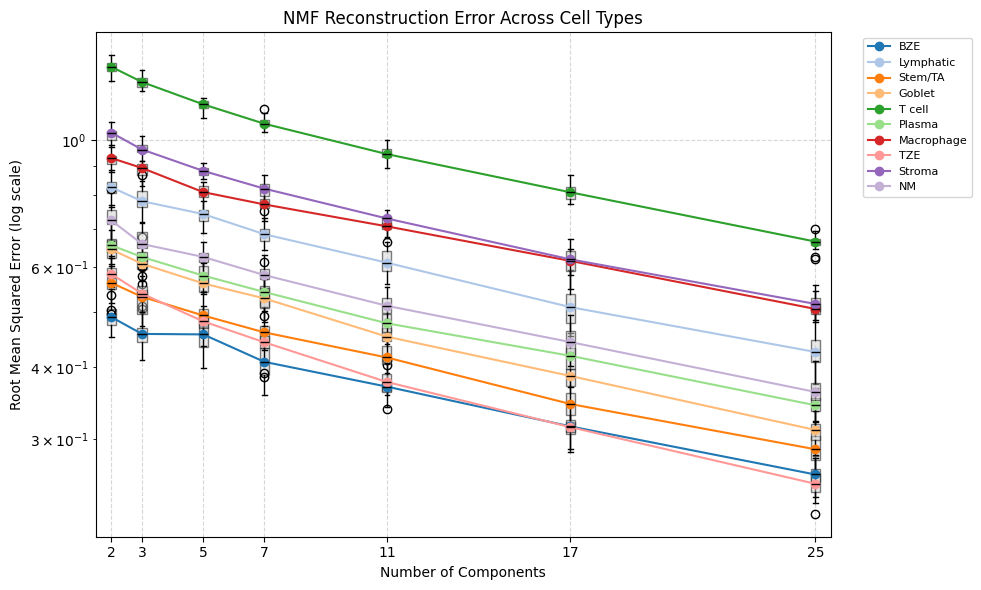

In [8]:
plt.figure(figsize=(10, 6))

palette = sns.color_palette("tab20", len(cell_types))
positions = list(n_components_range)
for i, n_components in enumerate(n_components_range):
    plt.boxplot(
        boxplot_data_reconstruction[n_components], 
        positions=[positions[i]] * len(cell_types),
        widths=0.3, 
        patch_artist=True, 
        boxprops=dict(facecolor="lightgray", alpha=0.5), 
        medianprops=dict(color='black')
    )

for i, (cell_type, color) in enumerate(zip(cell_types, palette)):
    median_values = [medians_reconstruction[n][i] for n in n_components_range]
    plt.plot(positions, median_values, marker="o", linestyle="-", color=color, label=cell_type)

plt.xticks(positions, n_components_range)  
plt.xlabel("Number of Components")
plt.ylabel("Root Mean Squared Error (log scale)")
plt.yscale("log")
#plt.xscale("log", base=1.5)
plt.title("NMF Reconstruction Error Across Cell Types")
plt.grid(True, linestyle="--", alpha=0.5)

plt.legend(loc="upper right", fontsize=8, bbox_to_anchor=(1.2, 1))
plt.tight_layout()
plt.show()

In [144]:
(lambda x: np.corrcoef(x["sample"].mean(axis=1), (x["output"][0] @ x["output"][1]).mean(axis=1)))(nmf_run["BZE"]["2"][0])[0, 1]

np.float64(0.4433490593033617)

In [22]:
adata_sc[adata_sc.obs["cluster"] == "BZE"].X.toarray()[:10, :10]

array([[ 0.,  0.,  0.,  0., 12.,  8., 11.,  0., 10.,  0.],
       [ 0.,  0.,  0.,  0., 14., 10.,  4.,  2., 11.,  3.],
       [ 0.,  0.,  0.,  0., 21.,  8.,  4.,  2.,  5.,  0.],
       [ 0.,  0.,  0.,  0., 11., 10.,  8.,  0.,  4.,  0.],
       [ 0.,  0.,  0.,  0., 12., 11.,  5.,  2., 12.,  4.],
       [ 0.,  0.,  0.,  0., 28.,  6.,  7.,  0.,  8.,  1.],
       [ 0.,  0.,  0.,  0., 18.,  7.,  6.,  4.,  9.,  0.],
       [ 0.,  0.,  0.,  0., 13.,  7., 10.,  1., 13.,  0.],
       [ 0.,  0.,  0.,  0., 23., 10.,  5.,  3.,  4.,  0.],
       [ 0.,  0.,  0.,  0., 17.,  6.,  5.,  5.,  8.,  0.]], dtype=float32)

(array([[1.716e+03, 3.900e+01, 0.000e+00, ..., 0.000e+00, 0.000e+00,
         0.000e+00],
        [1.754e+03, 1.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
         0.000e+00],
        [1.719e+03, 2.700e+01, 5.000e+00, ..., 0.000e+00, 0.000e+00,
         0.000e+00],
        ...,
        [1.748e+03, 7.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
         0.000e+00],
        [1.740e+03, 1.200e+01, 3.000e+00, ..., 0.000e+00, 0.000e+00,
         0.000e+00],
        [1.753e+03, 2.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
         0.000e+00]]),
 array([ 0.        ,  1.57225955,  3.14451909,  4.71677876,  6.28903818,
         7.86129761,  9.43355751, 11.00581646, 12.57807636, 14.15033627,
        15.72259521]),
 <a list of 203 BarContainer objects>)

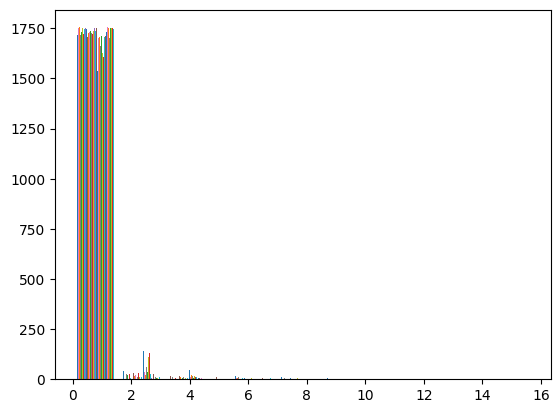

In [9]:
plt.hist(adata_sp[adata_sp.obs["nico_ct"] == "BZE"].X.toarray())

In [166]:
pd.DataFrame(nmf_run["BZE"]["2"][2]["sample"])

,0,1,2,3,4,5,6,7,8,9,...,193,194,195,196,197,198,199,200,201,202
0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,1.399541,0.088056,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
3,0.451291,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.212346,0.820993,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4,0.000000,0.000000,2.526654,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
96,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
97,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
98,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


(array([[ 99.,   1.,   0., ...,   0.,   0.,   0.],
        [100.,   0.,   0., ...,   0.,   0.,   0.],
        [ 98.,   1.,   0., ...,   0.,   0.,   0.],
        ...,
        [100.,   0.,   0., ...,   0.,   0.,   0.],
        [100.,   0.,   0., ...,   0.,   0.,   0.],
        [100.,   0.,   0., ...,   0.,   0.,   0.]]),
 array([ 0.        ,  1.57225955,  3.14451909,  4.71677876,  6.28903818,
         7.86129761,  9.43355751, 11.00581646, 12.57807636, 14.15033627,
        15.72259521]),
 <a list of 203 BarContainer objects>)

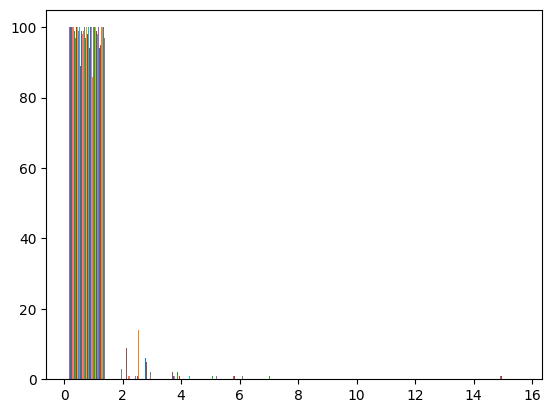

In [28]:
plt.hist(nmf_run["BZE"]["25"][2]["sample"])

(array([[100.,   0.,   0., ...,   0.,   0.,   0.],
        [100.,   0.,   0., ...,   0.,   0.,   0.],
        [100.,   0.,   0., ...,   0.,   0.,   0.],
        ...,
        [100.,   0.,   0., ...,   0.,   0.,   0.],
        [100.,   0.,   0., ...,   0.,   0.,   0.],
        [100.,   0.,   0., ...,   0.,   0.,   0.]]),
 array([ 0.        ,  1.60682774,  3.21365547,  4.82048321,  6.42731094,
         8.03413868,  9.64096642, 11.24779415, 12.85462189, 14.46144962,
        16.06827736]),
 <a list of 203 BarContainer objects>)

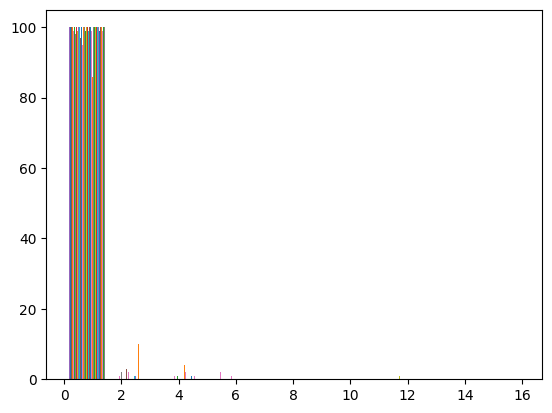

In [30]:
plt.hist((lambda x: (x["output"][0] @ x["output"][1]))((nmf_run["BZE"]["25"][0])))

In [31]:
adata_sp[adata_sp.obs["nico_ct"] == "BZE"].X.toarray()[:10, :10]

array([[0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       ],
       [0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       ],
       [0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       ],
       [0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       ],
       [0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       ],
       [0.4721131, 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 1.1353543, 0.       , 0.       ],
       [0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       ],
       [0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.     

In [35]:
nmf_run["BZE"]["25"][2]["sample"].shape

(100, 203)

In [70]:
adata_sp[adata_sp.obs["nico_ct"] == "BZE"]

View of AnnData object with n_obs × n_vars = 1755 × 203
    obs: 'umi_sct', 'log_umi_sct', 'gene_sct', 'log_gene_sct', 'umi_per_gene_sct', 'log_umi_per_gene_sct', 'leiden0.4', 'leiden0.5', 'nico_ct'
    var: 'Intercept_sct', 'log_umi_sct', 'theta_sct', 'Intercept_step1_sct', 'log_umi_step1_sct', 'dispersion_step1_sct', 'genes_step1_sct', 'log10_gmean_sct'
    uns: 'leiden', 'leiden0.5_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [95]:
W, H, n_iter = sklearn.decomposition.non_negative_factorization(adata_sp[adata_sp.obs["nico_ct"] == "T cell"].X.toarray(), n_components=200)


/opt/homebrew/Caskroom/miniforge/base/envs/scvi_mps-env/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


<Axes: >

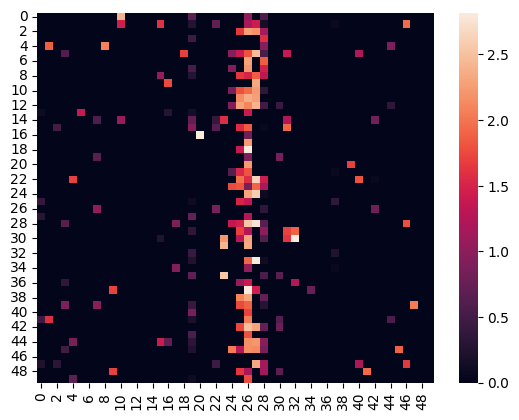

In [97]:
sns.heatmap(np.log1p(adata_sp[adata_sp.obs["nico_ct"] == "T cell"].X.toarray())[:50, :50])

<Axes: >

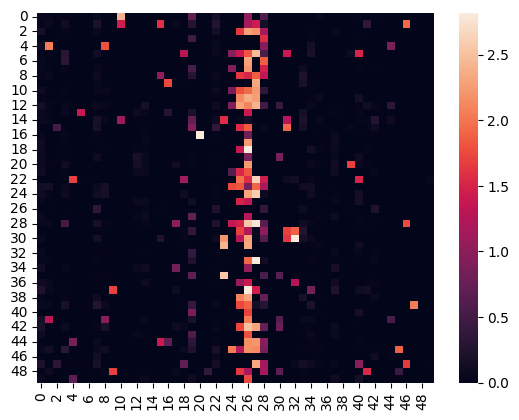

In [98]:
sns.heatmap(np.log1p(W @ H)[:50, :50])

<Axes: >

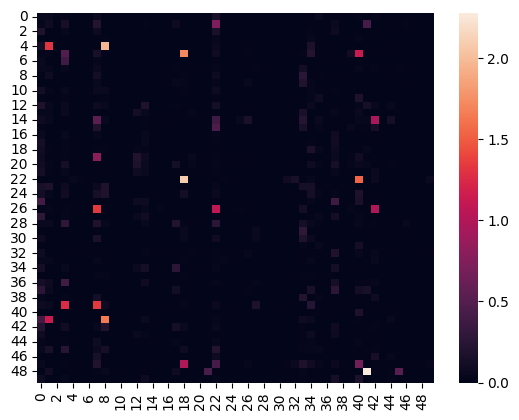

In [100]:
sns.heatmap((np.abs(adata_sp[adata_sp.obs["nico_ct"] == "T cell"].X.toarray() - (W @ H)))[:50, :50])

<Axes: >

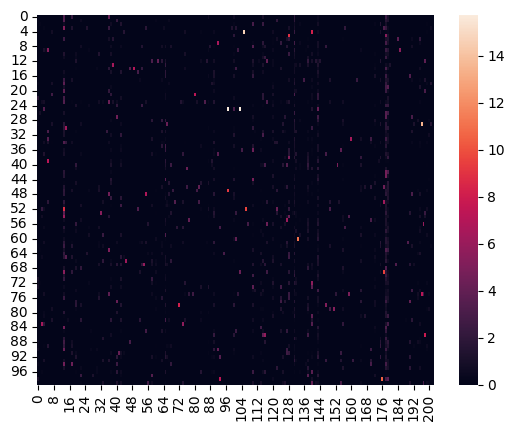

In [39]:
sns.heatmap(nmf_run["BZE"]["25"][2]["sample"])

<Axes: >

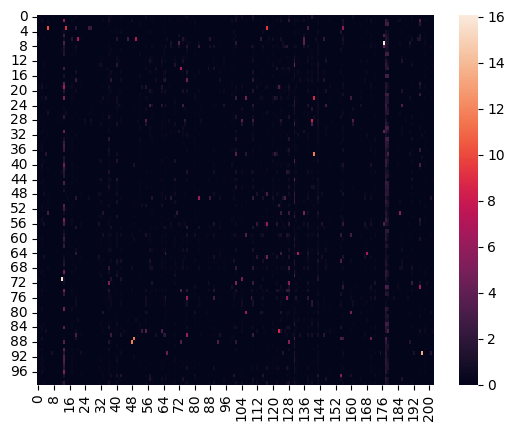

In [41]:
sns.heatmap((lambda x: (x["output"][0] @ x["output"][1]))((nmf_run["BZE"]["25"][0])))

In [121]:
adata_sp.obs["nico_ct"].value_counts()

nico_ct
BZE                        1755
Lymphatic                  1423
Stem/TA                     997
Goblet                      453
T cell                      448
Plasma                      437
Macrophage                  351
TZE                         308
Stroma                      259
NM                          236
Paneth                      184
Blood vasc.                 148
MZE                          95
cDC/monocyte                 88
Glial                        87
neurons/enteroendocrine      44
Rest B                       37
Tuft                         36
pDC                          16
Cycling/GC B cell            14
Name: count, dtype: int64

In [103]:
min(X.shape)

203

In [139]:
X[:, :-10]

array([[0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       ...,
       [2.73705  , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [2.9060988, 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ]], dtype=float32)

In [226]:
np.zeros(W.shape)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [282]:
shared_genes = list(set.intersection(set(adata_sc.var_names), set(adata_sp.var_names)))

In [285]:
shared_genes

['Slc2a2',
 'Lpar3',
 'Lmx1a',
 'C1qb',
 'Foxp3',
 'Cd44',
 'Jaml',
 'Neurog3',
 'Lpar6',
 'Tbxa2r',
 'Pax6',
 'Cd27',
 'Ffar1',
 'Sstr2',
 'Sstr3',
 'Ccr7',
 'H2-Eb1',
 'Icos',
 'Ifnar1',
 'Il3ra',
 'Cnr1',
 'Sox10',
 'Cadm1',
 'Hrh2',
 'Ffar4',
 'Cysltr2',
 'Cd8b1',
 'Scn3a',
 'Pzp',
 'Lpar5',
 'Fzd6',
 'Htr2b',
 'Fzd3',
 'Ptgfr',
 'S100b',
 'Rgs4',
 'Clca3b',
 'Mzb1',
 'Cd4',
 'Drd1',
 'Ly6g',
 'Ffar2',
 'Isl1',
 'Ccl9',
 'Ptprcap',
 'Fcgr4',
 'Htr7',
 'Fzd4',
 'Maoa',
 'Itgam',
 'Hhex',
 'Cd3d',
 'Net1',
 'Ptgdr2',
 'Gpr34',
 'Elavl3',
 'Ptger1',
 'Sell',
 'Txndc5',
 'Ptger4',
 'Sstr1',
 'Fzd8',
 'Tspan13',
 'P2ry10b',
 'Hmgb2',
 'Kit',
 'Cmc1',
 'Ptgir',
 'Cd34',
 'P2ry10',
 'Htr1b',
 'Kiss1r',
 'Fzd5',
 'Chrm1',
 'Lpar2',
 'Gpr174',
 'Lpar1',
 'Lamp3',
 'Scarb1',
 'C1qc',
 'Galr3',
 'Htr4',
 'Ccnl2',
 'Gpr119',
 'Marcksl1',
 'Rcor2',
 'Clec9a',
 'Il7r',
 'Tnfrsf21',
 'Slc26a4',
 'Fzd1',
 'Adra2a',
 'S1pr4',
 'Fcna',
 'Cspg4',
 'Avil',
 'Nlrp6',
 'Clec4a2',
 'Nt5e',
 'Cysltr1',
 '

In [288]:
adata_sc[:, "Slc2a2"]

View of AnnData object with n_obs × n_vars = 2239 × 1
    obs: 'cluster'
    var: 'n_counts'

In [291]:
shared_genes_mask = np.isin(adata_sc.var_names, adata_sp.var_names)

In [305]:
shared_genes_mask

array([False, False, False, ..., False, False, False])

In [292]:
adata_sc[:, shared_genes_mask]

View of AnnData object with n_obs × n_vars = 2239 × 187
    obs: 'cluster'
    var: 'n_counts'

In [571]:
shared_genes = list(adata_sc[:, shared_genes_mask].var_names)
X_sp = adata_sp[:, shared_genes].X.toarray().copy()
X_sc = adata_sc.X.toarray().copy()
X_sp = adata_sp[adata_sp.obs["nico_ct"] == "BZE"][:, shared_genes].X.toarray().copy()
X_sc = adata_sc[adata_sc.obs["cluster"] == "BZE"].X.toarray().copy()
n_components = min(X_sp.shape) - 10

In [572]:
W_init, H_init, n_iter = non_negative_factorization(X_sc, n_components=n_components, max_iter=500)

/opt/homebrew/Caskroom/miniforge/base/envs/scvi_mps-env/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(


In [573]:
W_ridge = Ridge(alpha=1.0, positive=True).fit(H_init[:, shared_genes_mask][:, :-1].T, X_sp[:, :-1].T).coef_

In [518]:
W, H, n_iter = non_negative_factorization(X_sp[:, :-1], H=H_init[:, shared_genes_mask][:, :-1], init="custom", update_H=False, max_iter=500, solver="mu")

<Axes: >

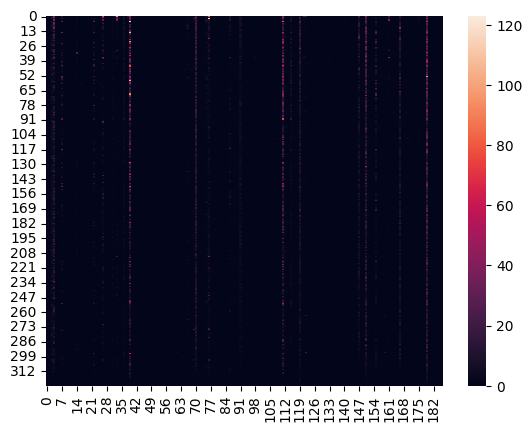

In [583]:
sns.heatmap(X_sc[:, shared_genes_mask])

<Axes: >

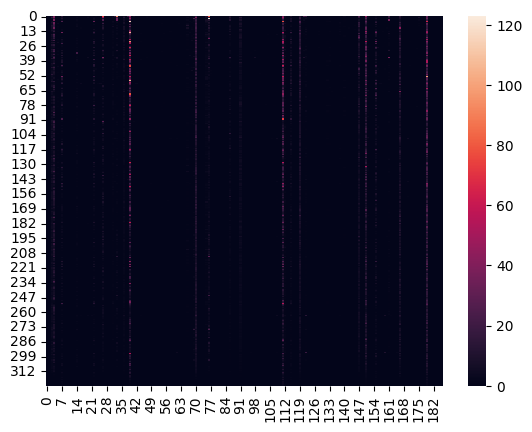

In [582]:
sns.heatmap((W_init @ H_init[:, shared_genes_mask]))

<Axes: >

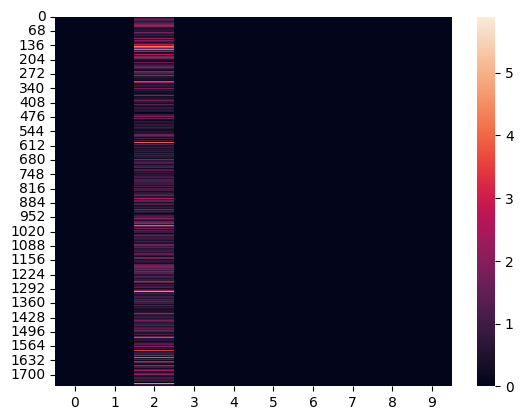

In [576]:
sns.heatmap((W_ridge @ H_init[:, shared_genes_mask][:, -10:]))

array([[2.4722840e-14, 6.5884913e-14, 1.6645548e-09, ..., 9.2712904e-09,
        5.0773880e-10, 3.3098669e-08],
       [6.7342899e-06, 1.0002887e-04, 7.6409806e-10, ..., 3.4681531e-08,
        4.9604847e-12, 1.2612985e-02],
       [6.8132294e-10, 9.3924239e-13, 6.6738788e-11, ..., 3.4542481e-08,
        0.0000000e+00, 2.6260884e-04],
       ...,
       [4.0708718e-04, 1.4523383e-06, 2.0664590e-06, ..., 5.4608001e-10,
        1.5385729e-05, 0.0000000e+00],
       [6.3911182e-07, 4.7564110e-12, 3.2507932e-13, ..., 1.3315835e-06,
        2.9249239e-10, 3.1193806e-02],
       [2.1147606e-27, 1.4733898e-11, 4.1607532e-18, ..., 2.1722111e-35,
        1.0253312e-10, 0.0000000e+00]], dtype=float32)

In [263]:
X_sp = adata_sp.X.toarray().copy()
X_sc = adata_sc.X.toarray().copy()
n_components = min(X_sp.shape) - 10
W_init, H_init, n_iter = non_negative_factorization(X_sc, n_components=n_components, max_iter=500)
W, H, n_iter = non_negative_factorization(X_sc[:, :-10], H=H_init[:, :-10], init="custom", update_H=False, max_iter=500, solver="cd")

/opt/homebrew/Caskroom/miniforge/base/envs/scvi_mps-env/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/scvi_mps-env/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(


In [270]:
X_sp.shape

(7416, 203)

In [269]:
(W @ H_init).shape

(2239, 18498)

In [561]:
X = adata_sp[adata_sp.obs["nico_ct"] == "T cell"].X.toarray().copy()
X_full = adata_sp.X.toarray().copy()
n_components = min(X.shape) - 10
W_init, H_init, _ = non_negative_factorization(X, n_components=n_components, max_iter=500)

In [ ]:
W, H, n_iter = non_negative_factorization(X[:, :-1], H=H_init[:, :-1], init="custom", update_H=False, max_iter=500, solver="cd")

In [562]:
from scipy.optimize import nnls

W_nnls = np.zeros((X.shape[0],n_components))  # W should have shape (n_samples, n_components)
for i in range(X.shape[0]):
    W_nnls[i, :] = nnls(H_init[:, :-1].T, X[:, :-1][i, :])[0]  # Solve for each row of W

In [563]:
from sklearn.linear_model import Ridge

W_ridge = Ridge(alpha=1.0, positive=True).fit(H_init[:, :-1].T, X[:, :-1].T).coef_

<Axes: >

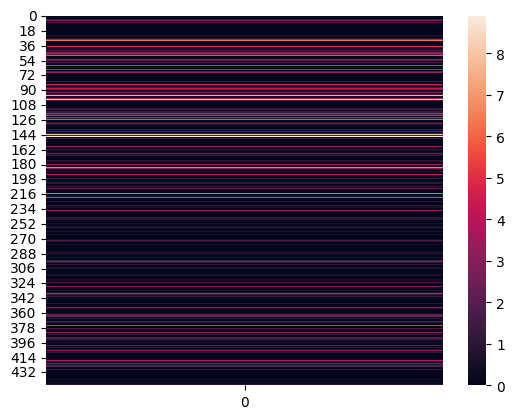

In [564]:
sns.heatmap(X[:, -1:])

<Axes: >

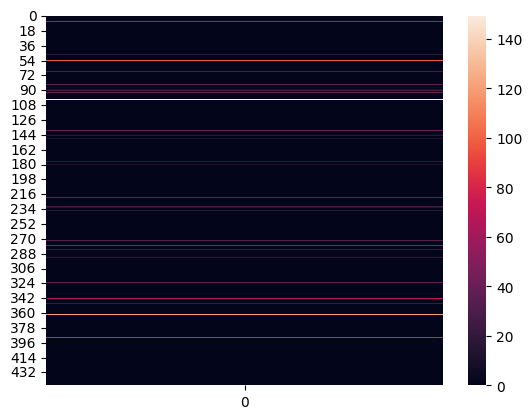

In [566]:
sns.heatmap(W @ H_init[:, -1:])

<Axes: >

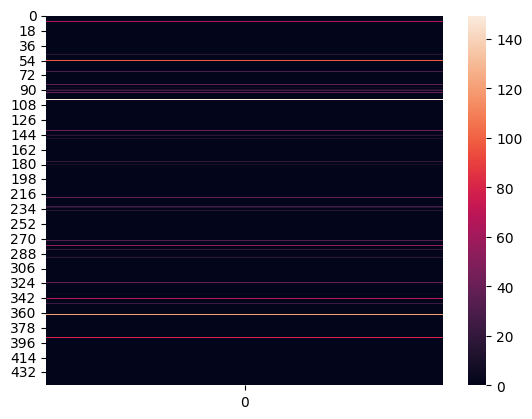

In [567]:
sns.heatmap(W_nnls @ H_init[:, -1:])

<Axes: >

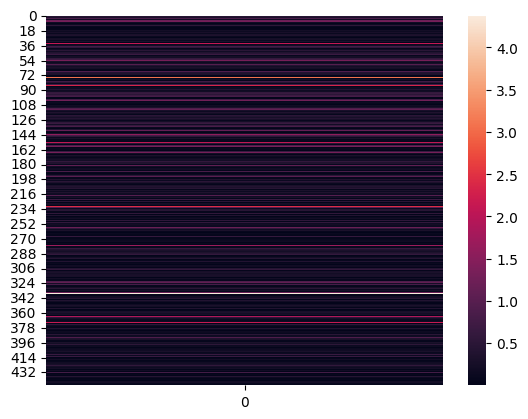

In [568]:
sns.heatmap(W_ridge @ H_init[:, -1:])

In [455]:
np.isin(adata_sp.var_names, )

NameError: name 'gene' is not defined

In [465]:
sklearn.metrics.pairwise.cosine_similarity()

TypeError: missing a required argument: 'X'

In [501]:
test[0][:]

(448, 202)

In [503]:
test = [(lambda x: x[0] @ H_init)(non_negative_factorization(X[:, ~np.isin(adata_sp.var_names, gene)], H=H_init[:, ~np.isin(adata_sp.var_names, gene)], init="custom", update_H=False))[:, np.isin(adata_sp.var_names, gene)] for gene in adata_sp.var_names[:20]]

In [505]:
testarray = functools.reduce(lambda a, b: np.hstack([a, b]), test)

<Axes: >

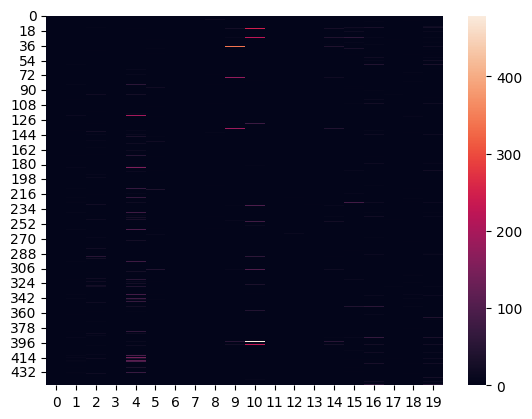

In [506]:
sns.heatmap(testarray)

<Axes: >

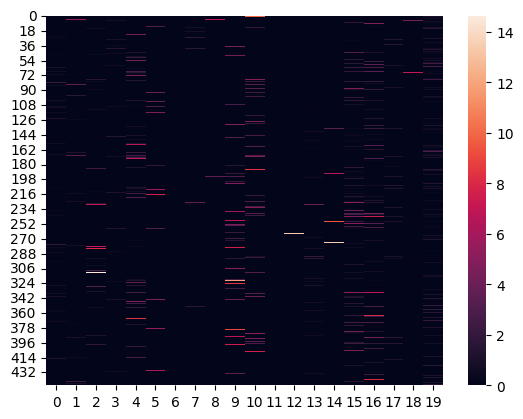

In [507]:
sns.heatmap(X[:, :20])

In [444]:
for gene in adata_sp.var_names

Index(['Acsl1', 'Acta2', 'Ada', 'Adgrd1', 'Adgrf5', 'Adra1a', 'Adra1b',
       'Adra2a', 'Adra2b', 'Adrb1',
       ...
       'Tigit', 'Tm4sf4', 'Tnfrsf21', 'Tpsb2', 'Trdc', 'Trpm5', 'Tspan13',
       'Txndc5', 'Vcan', 'Vim'],
      dtype='object', length=203)

In [400]:
np.zeros((10, n_components)).shape

(10, 193)

In [396]:
X[:, :-10].shape

(7416, 193)

In [411]:
W, H, n_iter = non_negative_factorization(np.hstack([X[:, :-10], np.zeros((X.shape[0], 10))]), H=np.hstack([H_init[:, :-10], np.zeros((H_init.shape[0], 10))]), init="custom", update_H=False, max_iter=500, solver="cd")

In [410]:
np.hstack([H_init[:, :-10], np.zeros((H_init.shape[0], 10))])

array([[1.57354414e-01, 2.27225418e+01, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 5.17811241e-05, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [7.33099878e-02, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.62348375e-01, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [7.12206006e-01, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [254]:
from scipy.linalg import lstsq

# Step 1: Run Initial NMF on Full Data
X_full = adata_sp.X.toarray().copy()
n_components = min(X_full.shape) - 10
W_init, H_init, _ = non_negative_factorization(X_full, n_components=n_components, max_iter=500)

# Step 2: Run NMF on Masked Data (Missing Last 10 Features)
X_masked = X_full[:, :-10]  # Only shared features
W, H, _ = non_negative_factorization(X_masked, H=H_init[:, :-10], init="custom", update_H=False, max_iter=500, solver="cd")

# Step 3: Solve for the Missing Features Using Least Squares
H_last10 = lstsq(W, X_full[:, -10:])[0]  # Solve W * H_last10 ≈ X[:, -10:]

# Step 4: Concatenate the Reconstructed Features
H_reconstructed = np.hstack([H, H_last10])

# Step 5: Reconstruct Full Data
X_reconstructed = W @ H_reconstructed

<Axes: >

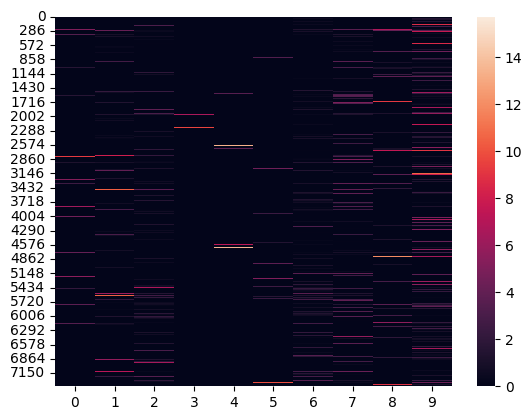

In [261]:
sns.heatmap(X_full[:, -10:])

<Axes: >

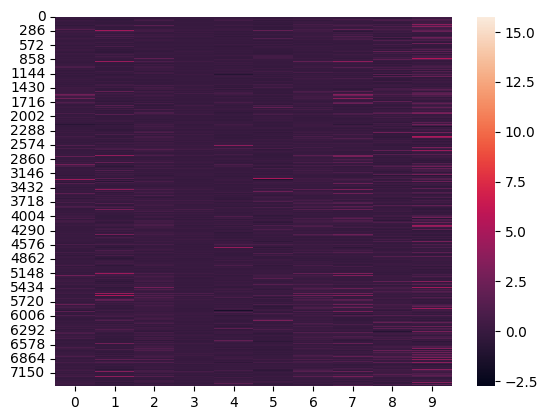

In [260]:
sns.heatmap(X_reconstructed[:, -10:])

<Axes: >

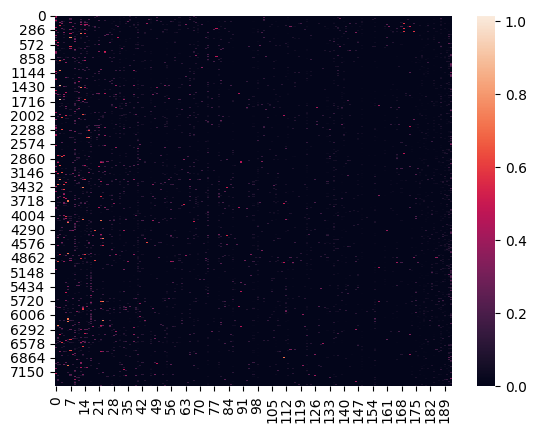

In [419]:
sns.heatmap(np.log1p(W_init))

<Axes: >

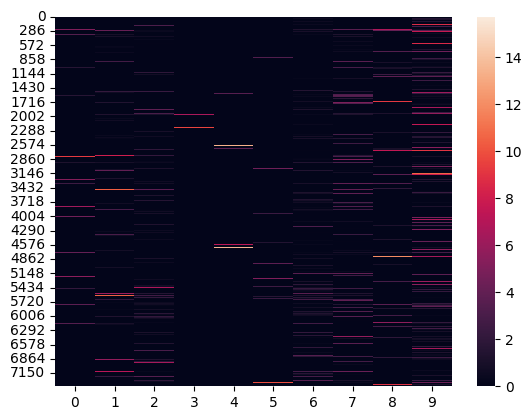

In [245]:
sns.heatmap(X[:, -10:])

<Axes: >

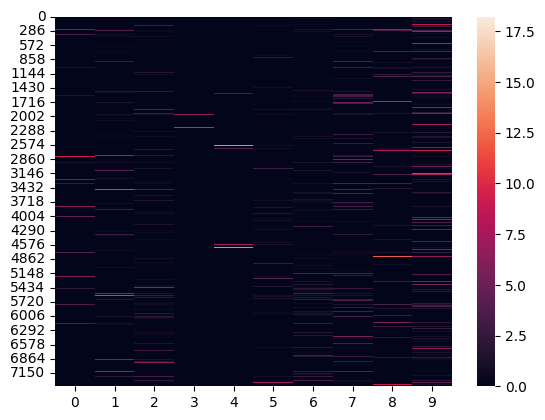

In [246]:
sns.heatmap(W_init @ H_init[:, -10:])

<Axes: >

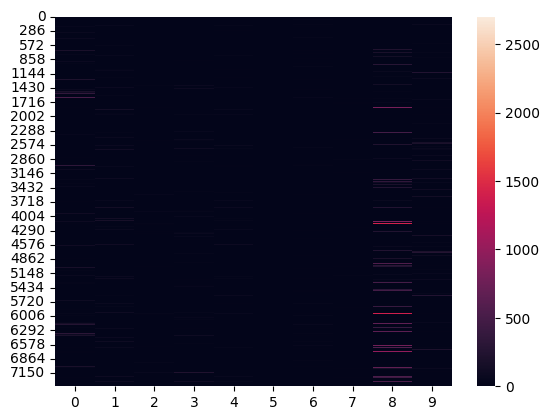

In [247]:
sns.heatmap(W @ H_init[:, -10:])

<Axes: >

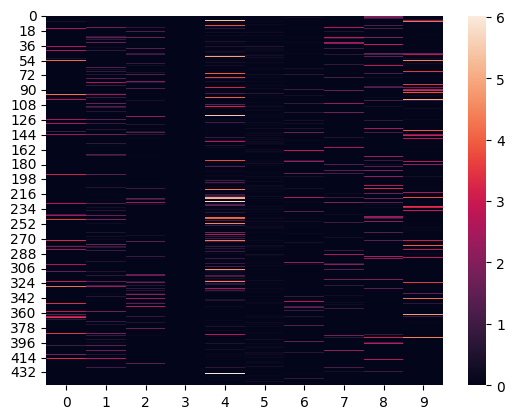

In [216]:
sns.heatmap(np.log1p(W @ H_init[:, -10:]))

In [181]:
H_init.shape

(193, 203)

<Axes: >

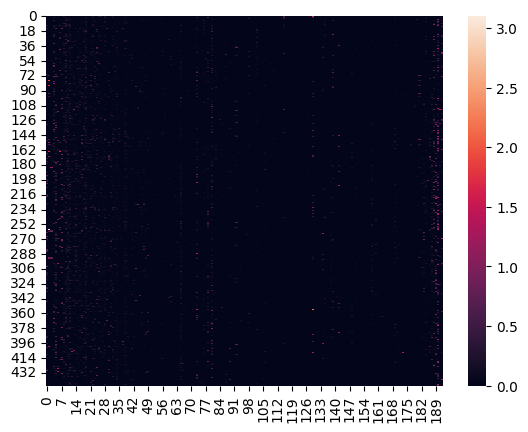

In [204]:
sns.heatmap(W_init)

<Axes: >

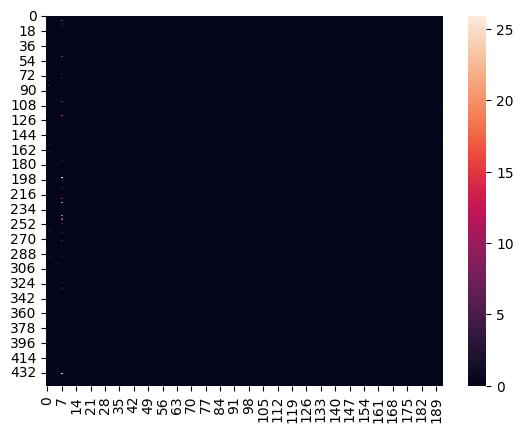

In [205]:
sns.heatmap(W)

<Axes: >

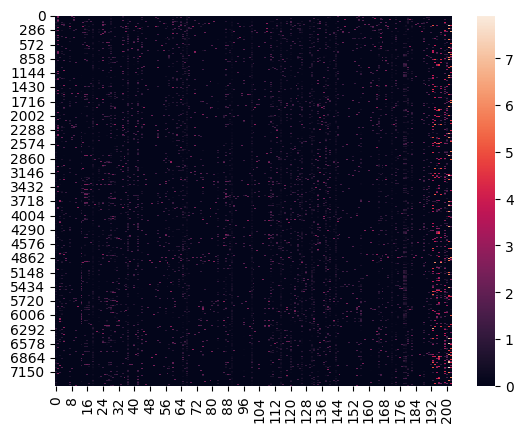

In [250]:
sns.heatmap(np.log1p(W @ H_init))

In [ ]:
@bootstrap(n_iterations=20, sample_size=100)
def non_negative_factorization_W_H_bootstrapped(data, n_components):
    return non_negative_factorization(X=data, n_components=n_components)[:2]


n_components_range = [int(2 ** x) for x in range(2, 9)] 
#n_components_range = [x for x in range(1, 16)]
cell_types = set.intersection(set(adata_sc.obs["cluster"]), set(adata_sp.obs["nico_ct"]))
cell_types = adata_sp.obs['nico_ct'].value_counts()[lambda counts: counts > 200].index.tolist()

nmf_run = {
    celltype: {
        str(n_components): non_negative_factorization_W_H_bootstrapped(
            np.nan_to_num(adata_sp[adata_sp.obs["nico_ct"] == celltype].X.toarray().copy()), n_components=n_components
        )
        for n_components in n_components_range
        } 
    for celltype in tqdm(cell_types)
}


In [ ]:
sns.heatmap()

In [145]:
boxplot_data_correlation_genes = {
    n_components: [
        [
            (lambda x: np.corrcoef(x["sample"].mean(axis=1), (x["output"][0] @ x["output"][1]).mean(axis=1)))(
                bootstrap_result
            )[0, 1]
            for bootstrap_result in nmf_run[celltype][str(n_components)]
        ] for celltype in cell_types
    ]
    for n_components in n_components_range
}

In [149]:
boxplot_data_correlation_cells = {
    n_components: [
        [
            (lambda x: np.corrcoef(x["sample"].mean(axis=0), (x["output"][0] @ x["output"][1]).mean(axis=0)))(
                bootstrap_result
            )[0, 1]
            for bootstrap_result in nmf_run[celltype][str(n_components)]
        ] for celltype in cell_types
    ]
    for n_components in n_components_range
}

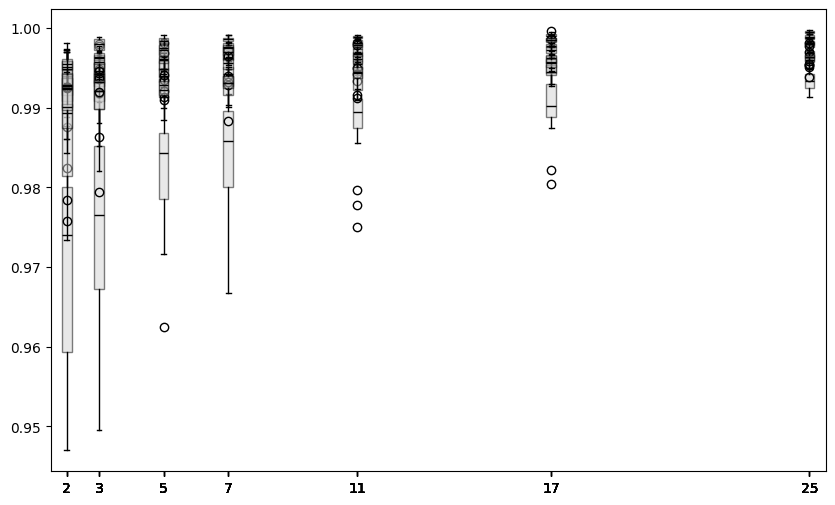

In [150]:
plt.figure(figsize=(10, 6))

palette = sns.color_palette("tab20", len(cell_types))
positions = list(n_components_range)
for i, n_components in enumerate(n_components_range):
    plt.boxplot(
        boxplot_data_correlation_cells[n_components], 
        positions=[positions[i]] * len(cell_types),
        widths=0.3, 
        patch_artist=True, 
        boxprops=dict(facecolor="lightgray", alpha=0.5), 
        medianprops=dict(color='black')
    )

In [ ]:
onstructionr='black')
    )

In [90]:
test = [sklearn.metrics.mean_squared_error(adata_sc.X.toarray(), (lambda nmf_res: nmf_res[0] @ nmf_res[1])(sklearn.decomposition.non_negative_factorization(adata_sc.X.toarray().copy(), n_components=n_components))) for n_components in range(2, 10)]
test

[208.2700653076172,
 157.1378631591797,
 107.60700225830078,
 76.12945556640625,
 64.87664794921875,
 57.263954162597656,
 49.57345199584961,
 42.11225891113281]

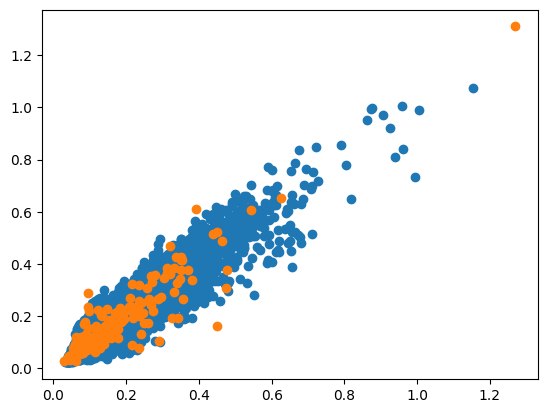

In [138]:
W, H, n_iter = sklearn.decomposition.non_negative_factorization(adata_sp.X.toarray().copy(), n_components=9)
X_r = W @ H
sklearn.metrics.mean_squared_error(adata_sp.X.toarray(), X_r)
plt.scatter(adata_sp.X.toarray().mean(axis=1), X_r.mean(axis=1))
plt.scatter(adata_sp.X.toarray().mean(axis=0), X_r.mean(axis=0))

In [91]:
W, H, n_iter = sklearn.decomposition.non_negative_factorization(adata_sc.X.toarray().copy(), n_components=9)
X_r = W @ H
sklearn.metrics.mean_squared_error(adata_sc.X.toarray(), X_r)
plt.scatter(adata_sc.X.toarray().mean(axis=1), X_r.mean(axis=1))

In [92]:
sklearn.metrics.mean_squared_error(adata_sc.X.toarray(), X_r)

42.11226272583008

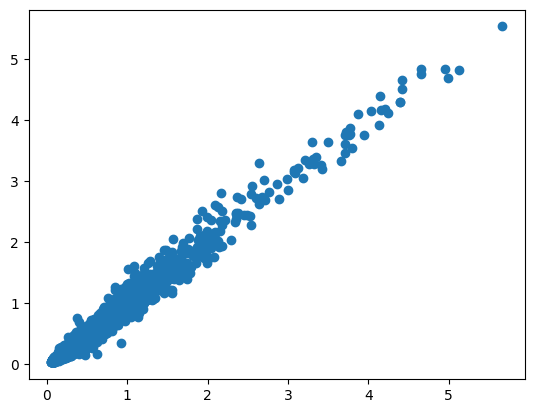

In [93]:
plt.scatter(adata_sc.X.toarray().mean(axis=1), X_r.mean(axis=1))

In [70]:
X_r.mean(axis=1)

array([50.469326, 51.501186, 49.19374 , ..., 61.41372 , 49.835167,
       62.452137], dtype=float32)

In [69]:
1 - (10080 / np.var(adata_sc.X.toarray()))

np.float32(0.59101546)

In [58]:
adata_sc.X.toarray().shape

(2239, 18498)

In [57]:
X_r.shape

(2239, 18498)

In [40]:
@bootstrap(n_iterations=20, sample_size=150)
def non_negative_factorization_W_H_bootstrapped(data, n_components):
    return non_negative_factorization(X=data, n_components=n_components)[:2]


n_components_range = [2 ** x for x in range(1, 7)]
#n_components_range = [x for x in range(1, 16)]
cell_types = set.intersection(set(adata_sc.obs["cluster"]), set(adata_sp.obs["nico_ct"]))
#cell_types = adata_sp.obs['nico_ct'].value_counts()[lambda counts: counts > 200].index.tolist()

nmf_run = {
    celltype: {
        str(n_components): non_negative_factorization_W_H_bootstrapped(
            np.nan_to_num(adata_sc[adata_sc.obs["cluster"] == celltype].X.toarray().copy()), n_components=n_components
        )
        for n_components in n_components_range
        } 
    for celltype in tqdm(cell_types)
}

boxplot_data_reconstruction = {
    n_components: [
        [
            (lambda bootstrap_result: sklearn.metrics.mean_squared_error(np.nan_to_num(bootstrap_result["sample"]), np.nan_to_num(bootstrap_result["output"][0] @ bootstrap_result["output"][1])))(
                bootstrap_result
            )
            for bootstrap_result in nmf_run[celltype][str(n_components)]
        ] for celltype in cell_types
    ]
    for n_components in n_components_range
}

medians_reconstruction = {n_components: [np.median(datapoints) for datapoints in data] for n_components, data in boxplot_data_reconstruction.items()}

  0%|          | 0/19 [00:00<?, ?it/s]/opt/homebrew/Caskroom/miniforge/base/envs/scvi_mps-env/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/scvi_mps-env/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/scvi_mps-env/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/scvi_mps-env/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/homebrew/Cask

In [ ]:
n_components_range = [x ** 2 for x in range(1, 8)]
n_repeats = 50 
sample_fraction = 0.4 
n_subsamples = int(min(adata_sp.obs["leiden0.5"].value_counts()) / 2)
cell_types = list(set.intersection(set(adata_sp.obs["nico_ct"]), set(adata_sc.obs["cluster"])))

palette = sns.color_palette("tab20", len(cell_types))
boxplot_data = {n: [] for n in n_components_range}
means = {n: [] for n in n_components_range}
medians = {n: [] for n in n_components_range}

for cell_type in tqdm(cell_types):
    X_full = adata_sp[adata_sp.obs["nico_ct"] == cell_type].X.toarray().copy()
    n_samples = X_full.shape[0]
    for n_components in n_components_range:
        mse_values = []
        for _ in range(n_repeats):
            #sampled_indices = np.random.choice(n_samples, int(sample_fraction * n_samples), replace=False)
            sampled_indices = np.random.choice(n_samples, min(n_samples, n_subsamples), replace=False)
            X_sampled = X_full[sampled_indices, :]
            W, H = non_negative_factorization(X_sampled, n_components=n_components, max_iter=500)[:2]
            X_reconstructed = W @ H
            mse = sklearn.metrics.mean_squared_error(X_sampled, X_reconstructed)
            mse_values.append(mse)
        boxplot_data[n_components].append(mse_values)
        means[n_components].append(np.mean(mse_values))
        medians[n_components].append(np.median(mse_values))

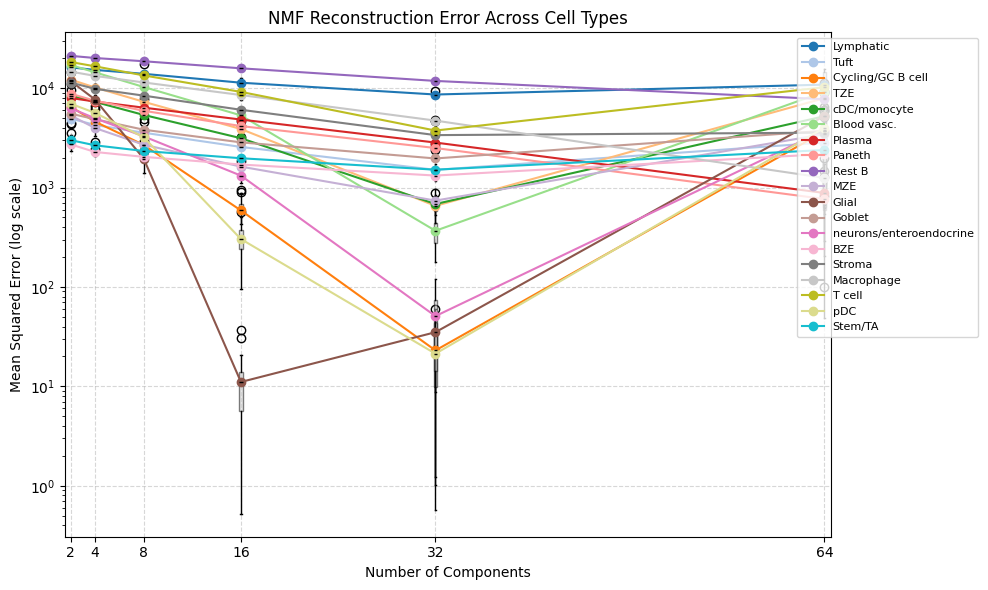

In [41]:
plt.figure(figsize=(10, 6))

palette = sns.color_palette("tab20", len(cell_types))
positions = list(n_components_range)
for i, n_components in enumerate(n_components_range):
    plt.boxplot(
        boxplot_data_reconstruction[n_components], 
        positions=[positions[i]] * len(cell_types),
        widths=0.3, 
        patch_artist=True, 
        boxprops=dict(facecolor="lightgray", alpha=0.5), 
        medianprops=dict(color='black')
    )

for i, (cell_type, color) in enumerate(zip(cell_types, palette)):
    median_values = [medians_reconstruction[n][i] for n in n_components_range]
    plt.plot(positions, median_values, marker="o", linestyle="-", color=color, label=cell_type)

plt.xticks(positions, n_components_range)  
plt.xlabel("Number of Components")
plt.ylabel("Mean Squared Error (log scale)")
plt.yscale("log")
#plt.xscale("log", base=2)
plt.title("NMF Reconstruction Error Across Cell Types")
plt.grid(True, linestyle="--", alpha=0.5)

plt.legend(loc="upper right", fontsize=8, bbox_to_anchor=(1.2, 1))
plt.tight_layout()
plt.show()

In [43]:
min(adata_sc.obs["cluster"].value_counts())

10

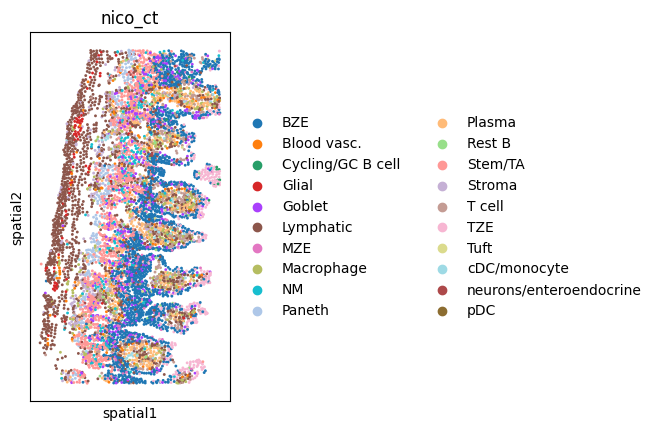

In [147]:
sc.pl.spatial(adata_sp, spot_size=80, color="nico_ct")

In [593]:
shared_genes = list(adata_sc[:, shared_genes_mask].var_names)
X_sp = adata_sp[:, shared_genes].X.toarray().copy()
X_sc = adata_sc.X.toarray().copy()
X_sp = adata_sp[adata_sp.obs["nico_ct"] == "BZE"][:, shared_genes].X.toarray().copy()
X_sc = adata_sc[adata_sc.obs["cluster"] == "BZE"].X.toarray().copy()
n_components = min(X_sp.shape) - 10

In [ ]:

W_init, H_init, n_iter = non_negative_factorization(X_sc, n_components=n_components, max_iter=500)

### (deep) neural network

#### linear, 1 layer

In [599]:
class lin_1l(torch.nn.Module):
    def __init__(self, n_input, n_output, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.l1 = torch.nn.Linear(n_input, n_output)
    def forward(self, x):
        return self.l1(x)

In [600]:
model = lin_1l(177, 1755)

<Axes: >

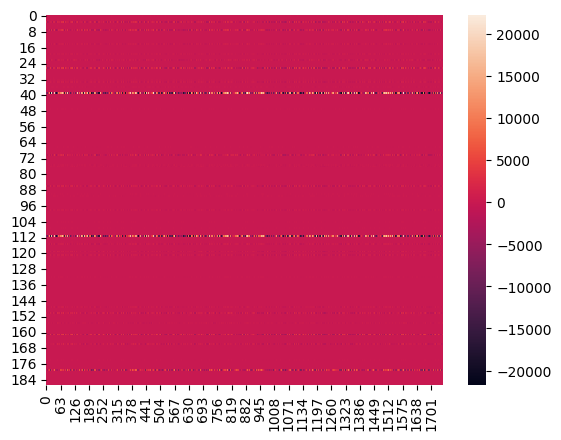

In [607]:
sns.heatmap(model(torch.Tensor(H_init[:, shared_genes_mask].T)).detach().numpy())